In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, classification_report, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [66]:
# функция оценки метрик
def metrics(y_true, y_preds, show=False):

    precision = precision_score(y_true, y_preds, zero_division=0)
    recall = recall_score(y_true, y_preds)
    f_score = f1_score(y_true, y_preds)
    accuracy = accuracy_score(y_true, y_preds)
    
    if show:
        return print('Precision=%.3f, Recall=%.3f, F_score=%.3f, Accuracy=%f' %(
        precision, recall, f_score, accuracy))
    else:
        return precision, recall, f_score, accuracy
    

In [67]:
df = pd.read_csv('monkeypox.csv')

In [68]:
df.head(3)

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,P0,None,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Patient_ID                      25000 non-null  object
 1   Systemic Illness                25000 non-null  object
 2   Rectal Pain                     25000 non-null  bool  
 3   Sore Throat                     25000 non-null  bool  
 4   Penile Oedema                   25000 non-null  bool  
 5   Oral Lesions                    25000 non-null  bool  
 6   Solitary Lesion                 25000 non-null  bool  
 7   Swollen Tonsils                 25000 non-null  bool  
 8   HIV Infection                   25000 non-null  bool  
 9   Sexually Transmitted Infection  25000 non-null  bool  
 10  MonkeyPox                       25000 non-null  object
dtypes: bool(8), object(3)
memory usage: 781.4+ KB


In [70]:
df.describe()

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
count,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,25000,4,2,2,2,2,2,2,2,2,2
top,P0,Fever,False,True,True,False,True,True,True,False,Positive
freq,1,6382,12655,12554,12612,12514,12527,12533,12584,12554,15909


In [71]:
def count_values(value):
    result = df[value].value_counts()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(value)
    bar = plt.bar(result.index, result)
    ax.set_ylabel('amount')
    ax.bar_label(bar)

In [72]:
df.drop('Patient_ID', axis=1, inplace=True)

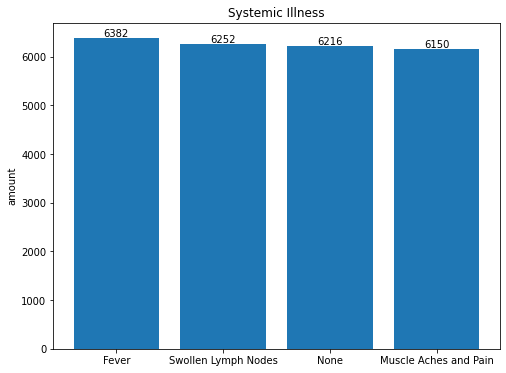

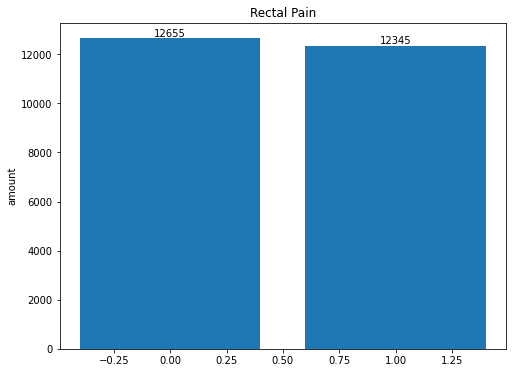

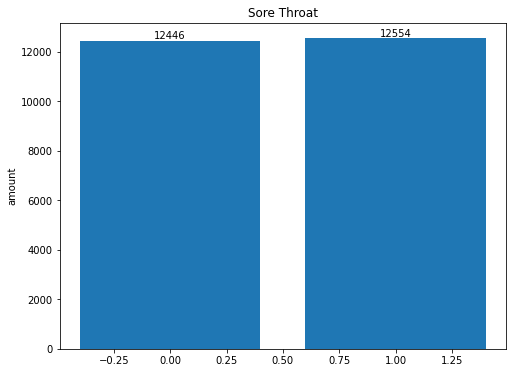

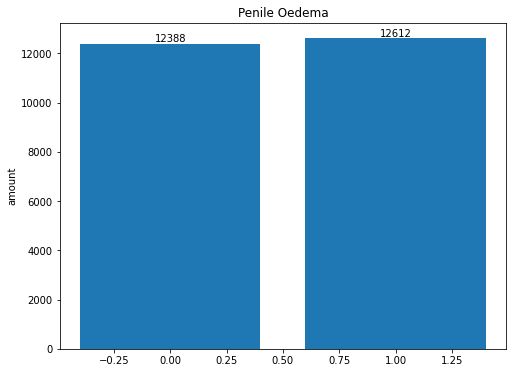

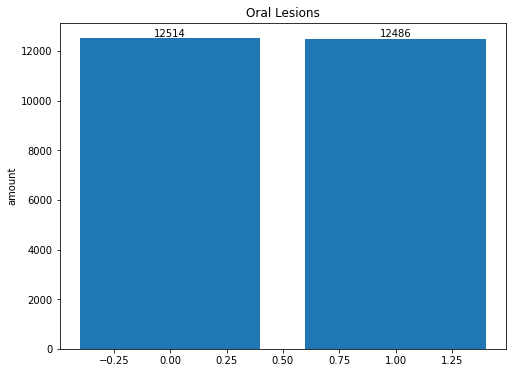

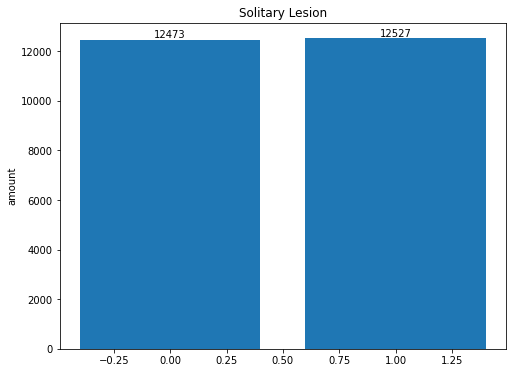

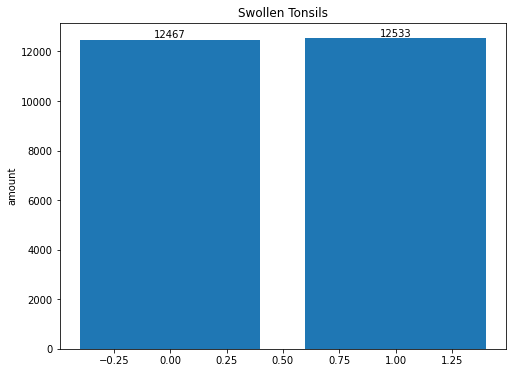

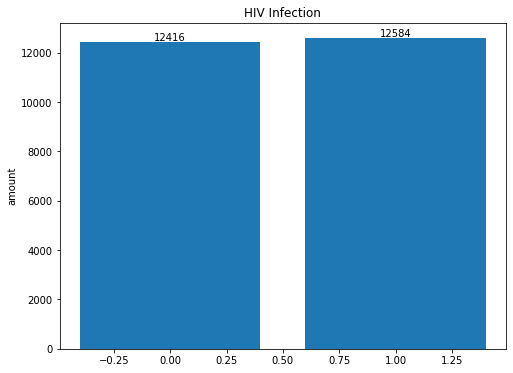

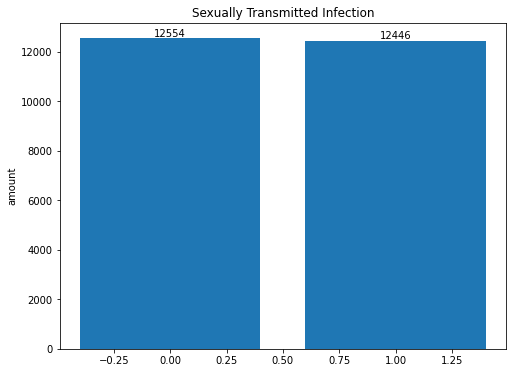

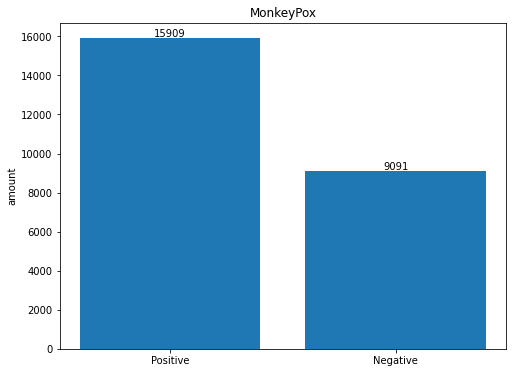

In [73]:
# посмотрим на данные
# почти везде идеально пополам разбиты, кроме баланса классов
for el in df.columns:
    count_values(el)

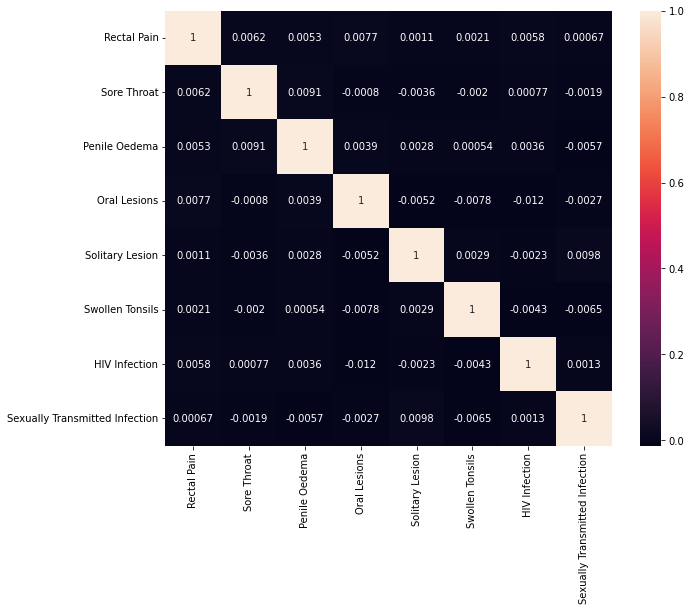

In [74]:
# Слабая отрицательная корреляция между всеми признаками, странно
coeffs = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(coeffs, annot=True);

In [75]:
boollean = df.select_dtypes('bool')
bool_columns = boollean.columns

for el in bool_columns:
    df[el] = np.where(df[el] == True, 1, 0)

In [76]:
df.MonkeyPox = np.where(df.MonkeyPox == 'Positive', 1, 0)

In [77]:
df = pd.get_dummies(df, columns=['Systemic Illness'])
df.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes
0,0,1,1,1,0,1,0,0,0,0,0,1,0
1,1,0,1,1,0,0,1,0,1,1,0,0,0
2,0,1,1,0,0,0,1,0,1,1,0,0,0
3,1,0,0,0,1,1,1,0,1,0,0,1,0
4,1,1,1,0,0,1,1,0,1,0,0,0,1


In [78]:
# Выбираем базовую модель
X = df.drop(['MonkeyPox'], axis=1)
y = df.MonkeyPox

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                   test_size=0.25)
X_train.shape, y_train.shape

((18750, 12), (18750,))

In [79]:
models_dict = {'Bagging': BaggingClassifier(),
               'RandomForest': RandomForestClassifier(),
              'Catboost': CatBoostClassifier(silent=True),
               'LGBM': LGBMClassifier(),
               'KNN': KNeighborsClassifier(),
              'Logreg': LogisticRegression()
              }
preds_dict = {}

In [80]:
for name, model in models_dict.items():        
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_dict[name] = preds


In [81]:
for name, preds in preds_dict.items():
    print(name)
    metrics(y_test, preds, show=True)

Bagging
Precision=0.715, Recall=0.859, F_score=0.780, Accuracy=0.687520
RandomForest
Precision=0.712, Recall=0.868, F_score=0.782, Accuracy=0.688000
Catboost
Precision=0.713, Recall=0.890, F_score=0.791, Accuracy=0.697120
LGBM
Precision=0.712, Recall=0.894, F_score=0.792, Accuracy=0.697600
KNN
Precision=0.708, Recall=0.790, F_score=0.747, Accuracy=0.653760
Logreg
Precision=0.722, Recall=0.862, F_score=0.786, Accuracy=0.696000


In [82]:
#разницы мало, посмотрим несколько штук в конце, возможно KNN и LogisticRegression

In [83]:
# соотношение классов 1.7 : 1. в пользу позитивных случаев
# Функция подготовки данных
def make_data(fr:float):
    ''' 0 < fr < 1
        возвращает готовые к делению данные и количество примененных позитивных едениц'''

    df_positive = df.loc[df.MonkeyPox == 1]
    df_negitive = df.loc[df.MonkeyPox == 0]
    n = round(df_positive.shape[0] * fr)
  
    positive_amount = df_positive.sample(n=n, random_state=42)
    positive_amount['learning_tag'] = 1

    rest_positive = df_positive.loc[~ df_positive.index.isin(positive_amount.index)]

    rest_amount = pd.concat([df_negitive, rest_positive])
    rest_amount = rest_amount.sample(frac=1)
    rest_amount['learning_tag'] = 0

    final_data = pd.concat([positive_amount, rest_amount]).sample(frac=1)
    return final_data, n

In [84]:
def education(final_data, model, train_shape, show=True):
    X = final_data.drop(['MonkeyPox', 'learning_tag'], axis=1)
    y = final_data.MonkeyPox
    fake_label = final_data.learning_tag

    model.fit(X[:train_shape].values, fake_label[:train_shape])
    predictions = model.predict(X[train_shape:].values)
    
    if show:
        metrics(y[train_shape:], predictions, show=show)
        
    else:
        precision, recall, f_score, accuracy  = metrics(y[train_shape:], predictions, show=show)
        return precision, recall, f_score, accuracy

In [85]:
# Ожидаемо, справляемся хуже чем на базовой модели, что-то сносное начинает получаться
# когда в ход идет 70%. позитивных случаев.
fr = np.arange(0.1, 0.8, 0.1)
for el in fr:
    final_data, n = make_data(el)
    print(f'Процент размеченных позитивных случаев в выборке {round(el * 100)}%, количество {n} ')
    education(final_data, model=LogisticRegression(max_iter=1000), train_shape=18000)

Процент размеченных позитивных случаев в выборке 10%, количество 1591 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.361286
Процент размеченных позитивных случаев в выборке 20%, количество 3182 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.375000
Процент размеченных позитивных случаев в выборке 30%, количество 4773 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.359143
Процент размеченных позитивных случаев в выборке 40%, количество 6364 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.358143
Процент размеченных позитивных случаев в выборке 50%, количество 7954 
Precision=0.850, Recall=0.022, F_score=0.042, Accuracy=0.375429
Процент размеченных позитивных случаев в выборке 60%, количество 9545 
Precision=0.869, Recall=0.168, F_score=0.282, Accuracy=0.448714
Процент размеченных позитивных случаев в выборке 70%, количество 11136 
Precision=0.804, Recall=0.412, F_score=0.545, Accuracy=0.562143


In [86]:
# Посмотрим на KNN

# А тут дела явно получше, нет нулей как в логистической регрессии
for el in fr:
    final_data, n = make_data(el)
    print(f'Процент размеченных позитивных случаев в выборке {round(el * 100)}%, количество {n} ')
    education(final_data, model=KNeighborsClassifier(n_neighbors=5, weights='uniform'), train_shape=18000)

Процент размеченных позитивных случаев в выборке 10%, количество 1591 
Precision=0.833, Recall=0.003, F_score=0.007, Accuracy=0.367714
Процент размеченных позитивных случаев в выборке 20%, количество 3182 
Precision=0.692, Recall=0.018, F_score=0.035, Accuracy=0.370286
Процент размеченных позитивных случаев в выборке 30%, количество 4773 
Precision=0.757, Recall=0.074, F_score=0.135, Accuracy=0.394714
Процент размеченных позитивных случаев в выборке 40%, количество 6364 
Precision=0.727, Recall=0.129, F_score=0.218, Accuracy=0.415429
Процент размеченных позитивных случаев в выборке 50%, количество 7954 
Precision=0.688, Recall=0.233, F_score=0.348, Accuracy=0.445714
Процент размеченных позитивных случаев в выборке 60%, количество 9545 
Precision=0.710, Recall=0.326, F_score=0.447, Accuracy=0.486143
Процент размеченных позитивных случаев в выборке 70%, количество 11136 
Precision=0.724, Recall=0.476, F_score=0.574, Accuracy=0.549857


In [87]:
# ну а мельком глянем на LGBM
for el in fr:
    final_data, n = make_data(el)
    print(f'Процент размеченных позитивных случаев в выборке {round(el * 100)}%, количество {n} ')
    education(final_data, model=LGBMClassifier(max_depth=7, n_estimators=300,), train_shape=18000)

Процент размеченных позитивных случаев в выборке 10%, количество 1591 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.366286
Процент размеченных позитивных случаев в выборке 20%, количество 3182 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.363000
Процент размеченных позитивных случаев в выборке 30%, количество 4773 
Precision=0.000, Recall=0.000, F_score=0.000, Accuracy=0.366571
Процент размеченных позитивных случаев в выборке 40%, количество 6364 
Precision=0.800, Recall=0.005, F_score=0.009, Accuracy=0.369143
Процент размеченных позитивных случаев в выборке 50%, количество 7954 
Precision=0.771, Recall=0.061, F_score=0.112, Accuracy=0.391286
Процент размеченных позитивных случаев в выборке 60%, количество 9545 
Precision=0.751, Recall=0.229, F_score=0.351, Accuracy=0.469000
Процент размеченных позитивных случаев в выборке 70%, количество 11136 
Precision=0.750, Recall=0.459, F_score=0.569, Accuracy=0.558143


In [88]:
# Таблицу построим на основе KNN
for name, preds in preds_dict.items():
    if name == 'KNN':
        pr, re, f, acc = metrics(y_test, preds)
r_final_data, r_n = make_data(0.7)
r_pr, r_re, r_f, r_acc = education(r_final_data, model=KNeighborsClassifier(n_neighbors=5, weights='uniform'),
                                   train_shape=18000, show=False)    
 

In [89]:
pd.DataFrame({'base knn': [pr, re, f, acc], 'random ns knn 70%':[r_pr, r_re, r_f, r_acc]},
             index=['precision', 'recall', 'f_score', 'accuracy'])

,base knn,random ns knn 70%
precision,0.708037,0.705996
recall,0.789747,0.492688
f_score,0.746664,0.580363
accuracy,0.653760,0.547571


In [90]:
# Как ни странно, почти не проседаем в точности, но очень теряем в полноте
# что недопустимо в медицинских задачах по этическим соображениям
# f мера тоже закономерно съехала вниз, но в целом при большом проценте позитивов это
# вполне работает